In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [25]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import time, copy
import random
from torch.autograd import Variable, grad

torch.manual_seed(0)
import math, random
import gym


from itertools import count
from PIL import Image
import torch.autograd as autograd 
from collections import namedtuple
from IPython.display import clear_output
%matplotlib inline
import numpy as np


# Sanity Check
print(torch.cuda.is_available())

False


## Cartpole Example

In [26]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [28]:
env_id = "CartPole-v0"
env = gym.make(env_id)

In [29]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
epsilon_by_frame = \
lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) *\
math.exp(-1. * frame_idx / epsilon_decay)

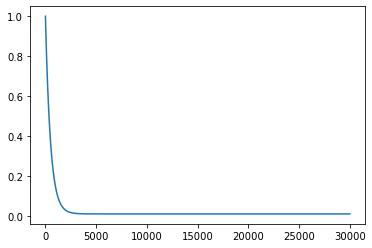

In [7]:
plt.plot([epsilon_by_frame(i) for i in range(30000)])

In [8]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )   
    def forward(self, x):
        return self.layers(x)
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [ ]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.yscale('log')
    plt.plot(losses)
    plt.show()

In [ ]:
def compute_td_loss(model, target, optimizer, batch_size, r1):
    state, action, reward,\
    next_state, done = replay_buffer.sample(batch_size)
    
    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done)) 
    
    # A simpler way of doing the same things. 
    q_values      = model(state)
    next_q_values = model(next_state)
    next_q_state_values = target(next_state) 
    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
    
    for parameter in model.parameters():
        if parameter.grad is not None:
            parameter.grad.zero_()
        if len(parameter.shape) > 1:
            gradient = grad(loss,parameter, create_graph = True)[0]
            u,s,v = torch.svd(gradient, compute_uv = True)
            parameter.grad= torch.mm(torch.mm(u, torch.diag(s+r1)), v.t())
        else:
            parameter.grad = grad(loss,parameter, create_graph = True)[0]       
    
    optimizer.step()   
    return loss

In [ ]:
for exp in [0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    for buff_size in [1000, 1500, 2000, 2500, 3000, 3500, 4000]:
        for eps in 
    ########################
    # The main loop 
    num_frames = 10000
    batch_size = 32
    gamma      = 0.99
    losses = []
    all_rewards = []
    episode_reward = 0
    state = env.reset()
    flag = 0
    exploration_rate = exp
    buffer_size  = 1000
    update_model = 30

    current_model = DQN(env.observation_space.shape[0], env.action_space.n)
    target_model  = DQN(env.observation_space.shape[0], env.action_space.n)
    optimizer_1   = optim.Adam(current_model.parameters() ) 
    optimizer_2   = optim.Adam(target_model.parameters() )

    replay_buffer = ReplayBuffer(buffer_size)
    for frame_idx in range(1, num_frames + 1):
        epsilon = epsilon_by_frame(frame_idx)
        if flag == 0:
            action = current_model.act(state, epsilon)
        else:
            action = target_model.act(state, epsilon)    
        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        if len(replay_buffer) > batch_size:
            if flag ==0:
                loss = compute_td_loss(current_model, target_model ,optimizer_1, batch_size, r1 = exploration_rate) 
            else:
                loss = compute_td_loss(target_model, current_model ,optimizer_2, batch_size, r1 = exploration_rate)      
            losses.append(loss.item())


        if frame_idx % update_model == 0:   
            exploration_rate = exploration_rate*0.99
            if flag == 0:
                flag = 1
            else:
                flag = 0

        if frame_idx%400 == 0:
             plot(frame_idx, all_rewards, losses) 
    current_model = None
    target_model  = None
    optimizer_1   = None
    optimizer_2   = None
    replay_buffer = None
    exploration_Rate = exp
    np.savetxt('data_ dualNN/rewards_'+str(buffer_size)+str(exploration_Rate)+'.csv', all_rewards, delimiter = ',')

In [ ]:
for exp in [1000, 1500, 2000, 2500, 3000, 3500, 4000]:
    ########################
    # The main loop 
    num_frames = 10000
    batch_size = 32
    gamma      = 0.99
    losses = []
    all_rewards = []
    episode_reward = 0
    state = env.reset()
    flag = 0
    exploration_rate = 0.5
    update_model = 30

    current_model = DQN(env.observation_space.shape[0], env.action_space.n)
    target_model  = DQN(env.observation_space.shape[0], env.action_space.n)
    optimizer_1   = optim.Adam(current_model.parameters() ) 
    optimizer_2   = optim.Adam(target_model.parameters() )

    replay_buffer = ReplayBuffer(exp)
    for frame_idx in range(1, num_frames + 1):
        epsilon = epsilon_by_frame(frame_idx)
        
        if flag == 0:
            action = current_model.act(state, epsilon)
        else:
            action = target_model.act(state, epsilon)    
            
        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        
        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        if len(replay_buffer) > batch_size:
            if flag ==0:
                loss = compute_td_loss(current_model, target_model ,optimizer_1, batch_size, r1 = exploration_rate) 
            else:
                loss = compute_td_loss(target_model, current_model ,optimizer_2, batch_size, r1 = exploration_rate)      
            losses.append(loss.item())


        if frame_idx % update_model == 0:   
            exploration_rate = exploration_rate*0.90
            if flag == 0:
                flag = 1
            else:
                flag = 0

        if frame_idx%400 == 0:
             plot(frame_idx, all_rewards, losses) 
                
    current_model = None
    target_model  = None
    optimizer_1   = None
    optimizer_2   = None
    replay_buffer = None
    np.savetxt('rewards_buff_'+str(exp)+str(exploration_Rate) +'.csv', all_rewards, delimiter = ',')

In [ ]:
for exp in [10, 20, 30, 50, 100, 150, 200]:
    ########################
    # The main loop 
    num_frames = 10000
    batch_size = 32
    gamma      = 0.99
    losses = []
    all_rewards = []
    episode_reward = 0
    state = env.reset()
    flag = 0
    exploration_rate = 0.5
    update_model = exp

    current_model = DQN(env.observation_space.shape[0], env.action_space.n)
    target_model  = DQN(env.observation_space.shape[0], env.action_space.n)
    optimizer_1   = optim.Adam(current_model.parameters() ) 
    optimizer_2   = optim.Adam(target_model.parameters() )

    replay_buffer = ReplayBuffer(4000)
    for frame_idx in range(1, num_frames + 1):
        epsilon = epsilon_by_frame(frame_idx)
        
        if flag == 0:
            action = current_model.act(state, epsilon)
        else:
            action = target_model.act(state, epsilon)    
            
        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        
        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        if len(replay_buffer) > batch_size:
            if flag ==0:
                loss = compute_td_loss(current_model, target_model ,optimizer_1, batch_size, r1 = exploration_rate) 
            else:
                loss = compute_td_loss(target_model, current_model ,optimizer_2, batch_size, r1 = exploration_rate)      
            losses.append(loss.item())


        if frame_idx % update_model == 0:   
            exploration_rate = exploration_rate*0.90
            if flag == 0:
                flag = 1
            else:
                flag = 0

        if frame_idx%400 == 0:
             plot(frame_idx, all_rewards, losses) 
                
    current_model = None
    target_model  = None
    optimizer_1   = None
    optimizer_2   = None
    replay_buffer = None
    np.savetxt('rewards_update_model_'+str(exp)+'.csv', all_rewards, delimiter = ',')

## Test on Gradients Methods

In [ ]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [ ]:
for exp in  [0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    ########################
    # The main loop 
    num_frames = 10000
    batch_size = 32
    gamma      = 0.99
    losses = []
    all_rewards = []
    episode_reward = 0
    state = env.reset()
    flag = 0
    exploration_rate = exp
    buffer_size  = 1000
    update_model = 30

    current_model = DQN(env.observation_space.shape[0], env.action_space.n)
    target_model  = DQN(env.observation_space.shape[0], env.action_space.n)
    optimizer   = optim.Adam(current_model.parameters() ) 
    # optimizer_2   = optim.Adam(target_model.parameters() )

    replay_buffer = ReplayBuffer(buffer_size)
    for frame_idx in range(1, num_frames + 1):
        epsilon = epsilon_by_frame(frame_idx)
        if flag == 0:
            action = current_model.act(state, epsilon)
        else:
            action = target_model.act(state, epsilon)    
        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(current_model, target_model ,optimizer, batch_size, r1 = exploration_rate) 
            losses.append(loss.item())
        if frame_idx % update_model == 0:
            update_target(current_model, target_model)
            exploration_rate = exploration_rate*0.99
        
        if frame_idx%400 == 0:
            plot(frame_idx, all_rewards, losses)     
                
                
                
    current_model = None
    target_model  = None
    optimizer_1   = None
    optimizer_2   = None
    replay_buffer = None
    exploration_Rate = exp
    np.savetxt('rewards_grad_'+str(buffer_size)+str(exploration_Rate)+'.csv', all_rewards, delimiter = ',')

In [ ]:
for exp in [1000, 1500, 2000, 2500, 3000, 3500, 4000]:
    ########################
    # The main loop 
    num_frames = 10000
    batch_size = 32
    gamma      = 0.99
    losses = []
    all_rewards = []
    episode_reward = 0
    state = env.reset()
    flag = 0
    exploration_rate = 0.5
    update_model = 30

    current_model = DQN(env.observation_space.shape[0], env.action_space.n)
    target_model  = DQN(env.observation_space.shape[0], env.action_space.n)
    optimizer   = optim.Adam(current_model.parameters() ) 

    replay_buffer = ReplayBuffer(exp)
    for frame_idx in range(1, num_frames + 1):
        epsilon = epsilon_by_frame(frame_idx)
        
        if flag == 0:
            action = current_model.act(state, epsilon)
        else:
            action = target_model.act(state, epsilon)    
            
        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        
        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(current_model, target_model ,optimizer, batch_size, r1 = exploration_rate) 
            losses.append(loss.item())
            
            
        if frame_idx % update_model == 0:
            update_target(current_model, target_model)
            exploration_rate = exploration_rate*0.99
        
        if frame_idx%400 == 0:
            plot(frame_idx, all_rewards, losses)     
                
                
    current_model = None
    target_model  = None
    optimizer_1   = None
    optimizer_2   = None
    replay_buffer = None
    np.savetxt('rewards_grad_buff_'+str(exp)+str(exploration_Rate) +'.csv', all_rewards, delimiter = ',')

In [ ]:
for exp in [10, 20, 30, 50, 100, 150, 200]:
    ########################
    # The main loop 
    num_frames = 10000
    batch_size = 32
    gamma      = 0.99
    losses = []
    all_rewards = []
    episode_reward = 0
    state = env.reset()
    flag = 0
    exploration_rate = 0.5
    update_model = exp

    current_model = DQN(env.observation_space.shape[0], env.action_space.n)
    target_model  = DQN(env.observation_space.shape[0], env.action_space.n)
    optimizer   = optim.Adam(current_model.parameters() ) 

    replay_buffer = ReplayBuffer(4000)
    for frame_idx in range(1, num_frames + 1):
        epsilon = epsilon_by_frame(frame_idx)
        
        if flag == 0:
            action = current_model.act(state, epsilon)
        else:
            action = target_model.act(state, epsilon)    
            
        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        
        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(current_model, target_model ,optimizer, batch_size, r1 = exploration_rate) 
            losses.append(loss.item())
            
            
        if frame_idx % update_model == 0:
            update_target(current_model, target_model)
            exploration_rate = exploration_rate*0.99
        
        if frame_idx%400 == 0:
            plot(frame_idx, all_rewards, losses)    
                
    current_model = None
    target_model  = None
    optimizer_1   = None
    optimizer_2   = None
    replay_buffer = None
    np.savetxt('rewards_grad_update_model_'+str(exp)+'.csv', all_rewards, delimiter = ',')

In [ ]:
########################
# The main loop 

num_frames = 10000
batch_size = 32
gamma      = 0.99
losses = []
all_rewards = []
episode_reward = 0
state = env.reset()
flag = 0
exploration_rate = 0.01
buffer_size  = 4000
update_model = 30

current_model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model  = DQN(env.observation_space.shape[0], env.action_space.n)
optimizer   =   optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(buffer_size)


for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(current_model, target_model ,optimizer, batch_size, r1 = exploration_rate) 
        losses.append(loss.item())
        
        
        if frame_idx % update_model == 0:
            update_target(current_model, target_model)
            exploration_rate = exploration_rate*0.99
        
        if frame_idx%400 == 0:
            plot(frame_idx, all_rewards, losses)     
            
# np.savetxt('rewards_dqn'+str(buffer_size)+'.csv', all_rewards, delimiter = ',')

##  Plotting things

In [7]:
lis =  [1000, 1500, 2000, 2500, 3000, 3500, 4000]

data_ours = []
data_grad = []


# ('rewards_buff_'+str(exp)+str(exploration_Rate)
 
 
for element in lis:
    data = np.loadtxt('rewards_buff_'+str(element)+'1.0.csv', delimiter = ',').reshape([-1,1])
    data = data[(data.shape[0]-70):,:]
    print(data.shape)
    data_ours.append(data)
    data = np.loadtxt('rewards_grad_buff_'+str(element)+'1.0.csv', delimiter = ',').reshape([-1,1])                                   
    print(data.shape)
    data = data[(data.shape[0]-70):,:]
    data_grad.append(data)

data_ours = np.array(data_ours).reshape([7,70])
data_grad = np.array(data_grad).reshape([7,70])
print(data_grad.shape)
print(data_ours.shape)

OSError: rewards_buff_10001.0.csv not found.

In [ ]:
# Let us create some plots with these
import matplotlib.pyplot as plt
def cm2inch(value):
    return value/2.54
small = 7
med = 10
large = 12
plt.style.use('seaborn-white')
COLOR = 'darkslategray'
params = {'axes.titlesize': small,
    'legend.fontsize': small,
    'figure.figsize': (cm2inch(8),cm2inch(5)),
    'axes.labelsize': med,
    'axes.titlesize': small,
    'xtick.labelsize': small,
    'ytick.labelsize': med,
    'figure.titlesize': small, 
    'font.family': "sans-serif",
    'font.sans-serif': "Myriad Hebrew",
        'text.color' : COLOR,
        'axes.labelcolor' : COLOR,
        'axes.linewidth' : 0.3,
        'xtick.color' : COLOR,
        'ytick.color' : COLOR}

plt.rcParams.update(params)
plt.rc('text', usetex = False)
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',\
     '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.rcParams['mathtext.fontset'] = 'cm'

from matplotlib.lines import Line2D
import matplotlib.font_manager as font_manager
large = 24; med = 8; small = 7


fig,a =  plt.subplots(1,1, sharex = False, dpi = 1000, gridspec_kw = {'wspace':0.3, 'hspace':0.3})
# Some Plot oriented settings 
a.spines["top"].set_visible(False)    
a.spines["bottom"].set_visible(False)    
a.spines["right"].set_visible(False)    
a.spines["left"].set_visible(True)  
a.grid(linestyle=':', linewidth=0.5)
a.get_xaxis().tick_bottom()    
a.get_yaxis().tick_left()  

mean = np.mean(data_ours, axis = 0)
std = np.std(data_ours, axis = 0)
t = np.arange(70)*(10000/70)
a.errorbar(t, mean, yerr = std, fmt = 'x', color = color[2], ms = 1, linewidth = 0.3, label = 'Double NN')
mean = np.mean(data_grad, axis = 0)
std = np.std(data_grad, axis = 0)
a.errorbar(t, mean, yerr = std, fmt = 'o', color = color[0], ms = 1, linewidth = 0.1, label = 'Single NN')
a.set_xlabel('Episode')
a.set_ylabel('Rewards')
a.legend()

plt.savefig('Rewards_Mean_value_diff_buffer_size.eps', dpi = 1000,  bbox_inches='tight')
    
plt.show()

In [23]:
# Let us create some plots with these
import matplotlib.pyplot as plt
def cm2inch(value):
    return value/2.54
small = 7
med = 8
large = 9
plt.style.use('seaborn-white')
COLOR = 'darkslategray'
params = {'axes.titlesize': small,
    'legend.fontsize': small,
    'figure.figsize': (cm2inch(4),cm2inch(1.5)),
    'axes.labelsize': med,
    'axes.titlesize': small,
    'xtick.labelsize': small,
    'ytick.labelsize': med,
    'figure.titlesize': small, 
    'font.family': "sans-serif",
    'font.sans-serif': "Myriad Hebrew",
        'text.color' : COLOR,
        'axes.labelcolor' : COLOR,
        'axes.linewidth' : 0.3,
        'xtick.color' : COLOR,
        'ytick.color' : COLOR}

plt.rcParams.update(params)
plt.rc('text', usetex = False)
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',\
     '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.rcParams['mathtext.fontset'] = 'cm'

from matplotlib.lines import Line2D
import matplotlib.font_manager as font_manager
large = 24; med = 8; small = 7


t = np.arange(70)*(10000/70)
lis = ['500', '1000', '1500', '2000', '3000', '4000', '5000']
marker = ['.', ',',     'o',    'v',    '1',     '2',    '3']




for i in range(data_ours.shape[0]):    
    fig,a =  plt.subplots(1,1, sharex = False, dpi = 1000, gridspec_kw = {'wspace':0.3, 'hspace':0.3})
    # Some Plot oriented settings 
    a.spines["top"].set_visible(False)    
    a.spines["bottom"].set_visible(False)    
    a.spines["right"].set_visible(False)    
    a.spines["left"].set_visible(True)  
    a.grid(linestyle=':', linewidth=0.5)
   
    a.errorbar(t, data_ours[i,:], yerr = 0.0001, fmt  = 'x',\
               color = color[2], ms = 3, linewidth = 0.3)
    a.plot(t,  data_ours[i,:], linewidth = 1, color = color[2])
    a.errorbar(t, data_grad[i,:], yerr = 0.0001, fmt = 'o',\
               color = color[0], ms = 3, linewidth = 0.1)
    a.plot(t,  data_grad[i,:], linewidth = 1, color = color[0])
    
    if i == 1:
        a.set_ylabel('Rewards')
        a.get_yaxis().tick_left()  
 
    else:
        a.set_yticks([])
        
    a.get_xaxis().tick_bottom()      
    a.set_xlabel('Episode')
    a.set_title('Buffer Size (' + lis[i] + ')')
    # a.legend(bbox_to_anchor=(-0.3, -0.6, 0.3, 0.1), loc = 'upper left',ncol=3, markerscale=1 )
    plt.savefig('Rewards_diff_buffer_size' + str(lis[i])+'.eps', dpi = 1000,  bbox_inches='tight')
    
plt.show()

AttributeError: 'list' object has no attribute 'shape'

In [24]:
for eps in [0, 0.0001, 0.01, 0.1, 0.2, 0.3, 0.5]:
    ########################
    # The main loop 
    num_frames = 10000
    batch_size = 32
    gamma      = 0.99
    losses = []
    all_rewards = []
    episode_reward = 0
    state = env.reset()
    flag = 0
    exploration_rate = eps
    buffer_size  = 4000
    update_model = 30

    current_model = DQN(env.observation_space.shape[0], env.action_space.n)
    target_model  = DQN(env.observation_space.shape[0], env.action_space.n)
    optimizer_1   = optim.Adam(current_model.parameters() ) 
    optimizer_2   = optim.Adam(target_model.parameters() )

    replay_buffer = ReplayBuffer(buffer_size)


    for frame_idx in range(1, num_frames + 1):
        epsilon = epsilon_by_frame(frame_idx)

        if flag == 0:
            action = current_model.act(state, epsilon)
        else:
            action = target_model.act(state, epsilon)


        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)


        state = next_state
        episode_reward += reward


        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        if len(replay_buffer) > batch_size:
            if flag ==0:
                loss = compute_td_loss(current_model, target_model ,optimizer_1, batch_size, r1 = exploration_rate) 
            else:
                loss = compute_td_loss(target_model, current_model ,optimizer_2, batch_size, r1 = exploration_rate)      
            losses.append(loss.item())
            
        if frame_idx % update_model == 0:   
            exploration_rate = exploration_rate*0.99
            if flag == 0:
                flag = 1
            else:
                flag = 0
        if frame_idx%400 == 0:
             plot(frame_idx, all_rewards, losses) 
    
    np.savetxt('rewards_ours_epsilon'+str(eps)+'.csv', all_rewards, delimiter = ',')
    current_model = None
    target_model  = None
    optimizer_1   = None
    optimizer_2   = None
    replay_buffer = None

NameError: name 'env' is not defined

In [ ]:


lis = [0, 0.0001, 0.01, 0.1, 0.2, 0.3, 0.5]
data_ours = []
data_grad = []
for element in lis:
    data = np.loadtxt('rewards_ours_epsilon'+str(element)+'.csv', delimiter = ',').reshape([-1,1])
    data = data[(data.shape[0]-55):,:]
    print(data.shape)
    data_ours.append(data)
    data = np.loadtxt('rewards_grad_epsilon'+str(element)+'.csv', delimiter = ',').reshape([-1,1])                                   
    print(data.shape)
    data = data[(data.shape[0]-55):,:]
    data_grad.append(data)

data_ours = np.array(data_ours).reshape([7,55])
data_grad = np.array(data_grad).reshape([7,55])
print(data_grad.shape)
print(data_ours.shape)

In [ ]:
# Let us create some plots with these
import matplotlib.pyplot as plt
def cm2inch(value):
    return value/2.54
small = 7
med = 8
large = 9
plt.style.use('seaborn-white')
COLOR = 'darkslategray'
params = {'axes.titlesize': small,
    'legend.fontsize': small,
    'figure.figsize': (cm2inch(8),cm2inch(5)),
    'axes.labelsize': med,
    'axes.titlesize': small,
    'xtick.labelsize': small,
    'ytick.labelsize': med,
    'figure.titlesize': small, 
    'font.family': "sans-serif",
    'font.sans-serif': "Myriad Hebrew",
        'text.color' : COLOR,
        'axes.labelcolor' : COLOR,
        'axes.linewidth' : 0.3,
        'xtick.color' : COLOR,
        'ytick.color' : COLOR}

plt.rcParams.update(params)
plt.rc('text', usetex = False)
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',\
     '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.rcParams['mathtext.fontset'] = 'cm'

from matplotlib.lines import Line2D
import matplotlib.font_manager as font_manager
large = 24; med = 8; small = 7


t = np.arange(55)*(6000/55)+4000
lis   =  ['SGD(Adam)', '0.0001', 'EDL(0.5)', '0.1', '0.2', '0.3', 'EDL(0.01)']
marker = ['.', ',',     'o',    'v',    '1',     '2',    '3']



fig,a =  plt.subplots(1,1, sharex = False, dpi = 1000, gridspec_kw = {'wspace':0.3, 'hspace':0.3})
# Some Plot oriented settings 
a.spines["top"].set_visible(False)    
a.spines["bottom"].set_visible(False)    
a.spines["right"].set_visible(False)    
a.spines["left"].set_visible(True)  
a.grid(linestyle=':', linewidth=0.5)

for i in [0, 2, 6]:   
#     mean = np.mean(data_ours[], axis = 0)
#     yerr = np.std(data_ours, axis = 0)
    
    mean = data_ours[i,:]
    yerr = 0.0001
    a.errorbar(t, mean, yerr = yerr, fmt  = marker[i],\
                   color = color[i], ms = 3, linewidth = 0.3, label = lis[i])
    a.plot(t,  mean, linewidth = 1, color = color[i])



#     mean = np.mean(data_grad, axis = 0)
#     yerr = np.std( data_grad, axis = 0)
#     a.errorbar(t, mean, yerr = yerr, fmt  = marker[1],\
#                    color = color[1], ms = 3, linewidth = 0.3, label = 'Single NN')
#     a.plot(t,  mean, linewidth = 1, color = color[1])    


a.set_ylabel('Rewards')
a.get_yaxis().tick_left()  
a.get_xaxis().tick_bottom()      
a.set_xlabel('Episodes')
# a.set_ylim([180,200])
# a.set_yscale('log')
# a.set_xscale('log')
a.legend(bbox_to_anchor=(-0.01, -0.3, 0.3, 0.1), loc = 'upper left',ncol=3, markerscale=1 )
plt.savefig('Rewards_diff_exploration_rate.eps', dpi = 1000,  bbox_inches='tight')
    
plt.show()                





In [ ]:
for eps in [0, 0.0001, 0.01, 0.1, 0.2, 0.3, 0.5]:
    ########################
    # The main loop 
    num_frames = 10000
    batch_size = 32
    gamma      = 0.99
    losses = []
    all_rewards = []
    episode_reward = 0
    state = env.reset()
    flag = 0
    exploration_rate = eps
    buffer_size  = 4000
    update_model = 30

    current_model = DQN(env.observation_space.shape[0], env.action_space.n)
    target_model  = DQN(env.observation_space.shape[0], env.action_space.n)
    optimizer   =   optim.Adam(current_model.parameters())

    replay_buffer = ReplayBuffer(buffer_size)


    for frame_idx in range(1, num_frames + 1):
        epsilon = epsilon_by_frame(frame_idx)
        action = current_model.act(state, epsilon)

        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward

        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(current_model, target_model ,optimizer, batch_size, r1 = exploration_rate) 
            losses.append(loss.item())


            if frame_idx % update_model == 0:
                update_target(current_model, target_model)
                exploration_rate = exploration_rate*0.99

            if frame_idx%400 == 0:
                plot(frame_idx, all_rewards, losses)    
                
                
    np.savetxt('rewards_grad_epsilon'+str(eps)+'.csv', all_rewards, delimiter = ',')
    current_model = None
    target_model  = None
    optimizer  = None
    replay_buffer = None
            
# np.savetxt('rewards_dqn'+str(buffer_size)+'.csv', all_rewards, delimiter = ',')

In [12]:

# Let us create some plots with these
import matplotlib.pyplot as plt
def cm2inch(value):
    return value/2.54
small = 7
med = 8
large = 9
plt.style.use('seaborn-white')
COLOR = 'darkslategray'
params = {'axes.titlesize': small,
    'legend.fontsize': small,
    'figure.figsize': (cm2inch(16),cm2inch(8)),
    'axes.labelsize': med,
    'axes.titlesize': small,
    'xtick.labelsize': small,
    'ytick.labelsize': med,
    'figure.titlesize': small, 
    'font.family': "sans-serif",
    'font.sans-serif': "Myriad Hebrew",
        'text.color' : COLOR,
        'axes.labelcolor' : COLOR,
        'axes.linewidth' : 0.3,
        'xtick.color' : COLOR,
        'ytick.color' : COLOR}

plt.rcParams.update(params)
plt.rc('text', usetex = False)
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',\
     '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.rcParams['mathtext.fontset'] = 'cm'

from matplotlib.lines import Line2D
import matplotlib.font_manager as font_manager
large = 24; med = 8; small = 7

def plot(frame_idx, rewards, losses):
    clear_output(True)
    fig,a =  plt.subplots(1,2, sharex = False, dpi = 200, gridspec_kw = {'wspace':0.3, 'hspace':0.3})
    # Some Plot oriented settings 
    a[0].spines["top"].set_visible(False)    
    a[0].spines["bottom"].set_visible(False)    
    a[0].spines["right"].set_visible(False)    
    a[0].spines["left"].set_visible(True)  
    a[0].grid(linestyle=':', linewidth=0.5)
    
    a[0].set_title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    a[0].plot(rewards)
    
    a[1].spines["top"].set_visible(False)    
    a[1].spines["bottom"].set_visible(False)    
    a[1].spines["right"].set_visible(False)    
    a[1].spines["left"].set_visible(True)  
    a[1].grid(linestyle=':', linewidth=0.5)
    a[1].plot(losses)
    a[1].set_title('frame %s. Loss: %s' % (frame_idx, np.mean(losses[-10:])))
    # a[1].set_yscale('log')

    plt.show()

In [13]:
def compute_td_loss(model, target, optimizer, batch_size, r1):
    state, action, reward,\
    next_state, done = replay_buffer.sample(batch_size)
    
    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done)) 
    
    # A simpler way of doing the same things. 
    q_values            = model(state)
    next_q_values       = model(next_state)
    next_q_state_values = target(next_state) 

    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
    
    for parameter in model.parameters():
        if parameter.grad is not None:
            parameter.grad.zero_()
        if len(parameter.shape) > 1:
            gradient = grad(loss,parameter, create_graph = True)[0]
            u,s,v = torch.svd(gradient, compute_uv = True)
            parameter.grad= torch.mm(torch.mm(u, torch.diag(s+r1)), v.t())
        else:
            parameter.grad = grad(loss,parameter, create_graph = True)[0]       
    optimizer.step()   

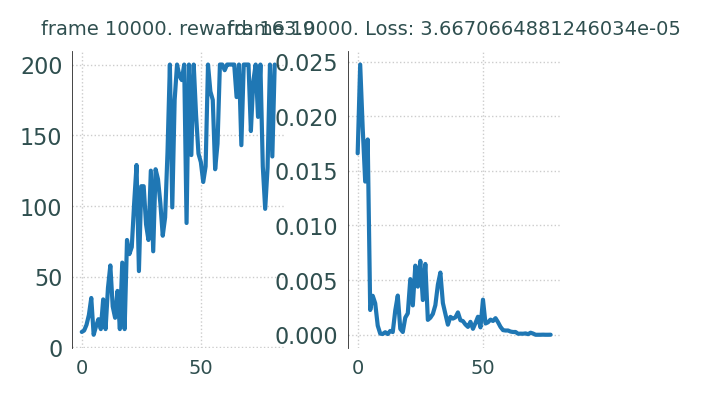

In [28]:

########################
# The main loop 
num_frames = 10000
batch_size = 64
gamma      = 0.99
current = []
target = []
all_loss = []
all_rewards = []
episode_reward = 0
state = env.reset()
flag = 0
exploration_rate = 0.1
buffer_size  = 5000
update_model = 10

current_model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model  = DQN(env.observation_space.shape[0], env.action_space.n)
optimizer_1   = optim.RMSprop(current_model.parameters(), lr = 0.01 ) 
optimizer_2   = optim.RMSprop(target_model.parameters(), lr = 0.01 )

replay_buffer = ReplayBuffer(buffer_size)
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    if flag == 0:
        action = current_model.act(state, epsilon)
    else:
        action = target_model.act(state, epsilon)
        
    
    current.append( current_model(Variable(torch.FloatTensor(np.float32(state)))).mean().item() )
    target.append(   target_model(Variable(torch.FloatTensor(np.float32(state)))).mean().item() )
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)

    state = next_state
    episode_reward += reward

    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        if len(replay_buffer) > batch_size:
            losses =  (np.array(current).reshape([-1]) - np.array(target).reshape([-1]))
            all_loss.append( np.square(losses.mean().item()) )
    

    if len(replay_buffer) > batch_size:
        if flag ==0:
            compute_td_loss(current_model, target_model ,optimizer_1, batch_size, r1 = exploration_rate) 
        else:
            compute_td_loss(target_model, current_model ,optimizer_2, batch_size, r1 = exploration_rate)      

    if frame_idx % update_model == 0:   
        exploration_rate = exploration_rate*0.99
        if flag == 0:
            flag = 1
        else:
            flag = 0   

            
    if frame_idx%400 == 0:
         plot(frame_idx, all_rewards, all_loss) 

            
np.savetxt('LOSS.csv', all_loss, delimiter = ',')
np.savetxt('Rewards.csv', all_rewards, delimiter = ',')

current_model = None
target_model  = None
optimizer_1   = None
optimizer_2   = None
replay_buffer = None

In [4]:
from scipy.ndimage import gaussian_filter1d

In [5]:
L = np.loadtxt('LOSS.csv', delimiter = ',')
Rewards = np.loadtxt('Rewards.csv', delimiter = ',')        
# L = gaussian_filter1d(L, 5)             

In [ ]:
# Let us create some plots with these
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import seaborn as sns
import matplotlib.font_manager as font_manager
import itertools as iters
from scipy.ndimage import gaussian_filter
def cm2inch(value):
    return value/2.54
small = 7
med = 8
large = 9
plt.style.use('seaborn-white')
COLOR = 'darkslategray'
params = {'axes.titlesize': small,
    'legend.fontsize': small,
    'figure.figsize': (cm2inch(8),cm2inch(5)),
    'axes.labelsize': med,
    'axes.titlesize': small,
    'xtick.labelsize': small,
    'ytick.labelsize': med,
    'figure.titlesize': small, 
    'font.family': "sans-serif",
    'font.sans-serif': "Myriad Hebrew",
        'text.color' : COLOR,
        'axes.labelcolor' : COLOR,
        'axes.linewidth' : 0.3,
        'xtick.color' : COLOR,
        'ytick.color' : COLOR}

plt.rcParams.update(params)
plt.rc('text', usetex = False)
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',\
     '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.rcParams['mathtext.fontset'] = 'cm'

from matplotlib.lines import Line2D
import matplotlib.font_manager as font_manager
large = 24; med = 8; small = 7
fil =0.1

i=5
lis   =  ['SGD(Adam)', '0.0001', 'EDL(0.5)', '0.1', '0.2', '0.3', 'EDL(0.01)']
marker = ['.', ',',     'o',    'v',    '1',     '2',    '3']
fig,a =  plt.subplots(1,2, figsize=(9,3), dpi=400,  gridspec_kw = {'wspace':0.2, 'hspace':0.2})
# Some Plot oriented settings 
a[0].spines["top"].set_visible(True)    
a[0].spines["bottom"].set_visible(True)    
a[0].spines["right"].set_visible(True)    
a[0].spines["left"].set_visible(True)  
a[0].grid(linestyle=':', linewidth=0.5)

t = np.arange(len(L))*(10000/len(L))
mean = gaussian_filter1d(L.reshape([-1]), fil)
a[0].errorbar(t, mean, yerr = 0.00001, fmt  = marker[i],\
color = color[2], ms = 3, linewidth = 0.001)
a[0].plot(t, mean, linewidth = 1, color = color[2])

# a[0].set_ylim([0, 0.0025])
# a[0].set_yscale('log')
a[0].set_ylabel('$||Q^{1} - Q^{2}||^2$')
a[0].get_yaxis().tick_left()  
a[0].get_xaxis().tick_bottom()      
# a[0].set_xlabel('Episodes')
a[0].set_xlabel('Episodes')
i=2
folder_ = '/home/kraghavan/Projects/RL/RL_Cartpole/'
file_name= folder_+'data_dual_NN_EDL/rewards_dual_default_v3_.csv'
data= np.loadtxt(file_name, delimiter = ',').reshape([-1,1])
print(data.shape)
mean = gaussian_filter1d(data.reshape([-1]), fil)
t = np.arange(mean.shape[0])*(10000/mean.shape[0])
a[1].errorbar(t, mean, yerr = 0.00001, fmt  = marker[i],\
                   color = color[0], ms = 3, linewidth = 0.001, label = 'coop(1)')
a[1].plot(t, mean, linewidth = 1, color = color[0])



file_name= folder_+'data_single_NN_EDL/rewards_default_v2_.csv'
data= np.loadtxt(file_name, delimiter = ',').reshape([-1,1])
mean = gaussian_filter1d(data.reshape([-1]), fil)
t = np.arange(mean.shape[0])*(10000/mean.shape[0])
a[1].errorbar(t, mean, yerr = 0.00001, fmt  = marker[i],\
                   color = color[2], ms = 3, linewidth = 0.001, label = 'coop(0.1)')
a[1].plot(t, mean, linewidth = 1, color = color[2])




from matplotlib.ticker import AutoMinorLocator
a[0].yaxis.set_minor_locator(AutoMinorLocator())
a[0].tick_params(axis="y", direction="in", length=2)
a[0].tick_params(axis="x", direction="in", length=2)
a[0].xaxis.set_minor_locator(AutoMinorLocator())
# a[0].set_xlim([0,0.01])


# file_name= folder_+'data_single_NN_SGD/rewards_default_v2_.csv'
# data= np.loadtxt(file_name, delimiter = ',').reshape([-1,1])
# mean = gaussian_filter1d(data.reshape([-1]), 0.01)
# t = np.arange(mean.shape[0])*(10000/mean.shape[0])
# a[1].errorbar(t, mean, yerr = 0.00001, fmt  = marker[i],\
#                    color = color[1], ms = 3, linewidth = 0.001, label = 'SGD')
# a[1].plot(t, mean, linewidth = 1, color = color[1])


i=3
file_name=folder_+'data_dual_NN_SGD/rewards_default_v2_.csv'
data= np.loadtxt(file_name, delimiter = ',').reshape([-1,1])
print(data.shape)
mean = gaussian_filter1d(data.reshape([-1]), fil)
t = np.arange(mean.shape[0])*(10000/mean.shape[0])
a[1].errorbar(t, mean, yerr = 0.00001, fmt  = marker[i],\
                   color = color[4], ms = 3, linewidth = 0.001, label = 'G-coop')
a[1].plot(t, mean, linewidth = 1, color = color[4])



a[1].set_ylabel('Rewards')
a[1].get_yaxis().tick_left()  
a[1].get_xaxis().tick_bottom()      
a[1].set_xlabel('Episodes')
a[1].tick_params(axis="x", direction="in", length=2)
a[1].tick_params(axis="y", direction="in", length=2)
a[1].xaxis.set_minor_locator(AutoMinorLocator())
a[1].yaxis.set_minor_locator(AutoMinorLocator())
a[1].spines["top"].set_visible(True)    
a[1].spines["bottom"].set_visible(True)    
a[1].spines["right"].set_visible(True)    
a[1].spines["left"].set_visible(True)  
a[1].grid(linestyle=':', linewidth=0.5)
# a[1].get_yaxis().set_major_locator()
# a[1].set_ylim([175,200])
# a[1].set_yscale('log')
#a1.set_xscale('log')

a[1].legend( loc = 'lower right',ncol=1, markerscale=1)
#a[0].text(-3000, 0.028, 'A.', fontsize=15)
#a[1].text(-3200, 200, 'B.', fontsize=15)

plt.savefig('diff_two_network.png', dpi = 400,  bbox_inches='tight')    
plt.show()                




